### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.


Notes:
ideally, I want to use time-based cross-validation.
since I have panel data, it is not a trivial task.
need to find some solution online.
e.g., https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8.


In [100]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, time, math, re, warnings, random, gc, dill, optuna
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [101]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [102]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [103]:
# 1. Import data #

min_prd = 381

time0 = time.time()
df = pd.read_csv('../input/cpcrsp-46/IMLEAP_v4.csv')
df.dropna(axis=0, subset=['bm', 'lbm', 'llme', 'lop', 'op', 'linv', 'mom122', 'beta_bw', 'ind'], inplace=True)
df.reset_index(inplace=True, drop=True)
#df = df.sample(500000)
df = df[df.year.isin(range(1990, 2010))]
display(df.shape, df.head(), df.count())

(581451, 46)

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m
6,10005,381,NaN,-65.203618,1990,-0.57,30.0,0.490174,-0.214332,0.0,-0.230583,-0.610000,-38.367763,NaN,0.765013,0.647098,0.522012,1.4066,0.866870,4.132801,3.099129,NaN,-0.647218,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,21.135115,NaN,-37.167231,0.765013,0.647098,0.710294,4.235715,3.516000
7,10005,382,NaN,-65.224843,1990,-25.57,30.0,0.490174,-0.214332,0.0,-0.230583,-0.570000,-38.404947,NaN,0.765013,0.647098,0.499827,1.4066,0.866870,4.132835,3.099130,NaN,-0.647218,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.659716,0.765013,0.647098,0.735236,3.367831,3.336151
8,10005,383,NaN,-72.706514,1990,-0.64,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.380158,NaN,5.732938,5.391287,0.492262,1.4066,5.455535,4.690786,3.473044,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.710657,0.765013,0.647098,0.741531,3.367760,3.336121
9,10005,384,NaN,-67.514581,1990,-0.69,30.0,0.490174,-0.214332,0.0,-0.230583,-0.640000,-53.826992,NaN,0.765013,0.647098,0.493277,1.4066,0.866870,3.725968,3.473051,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.806772,0.765013,0.647098,0.750895,2.328417,3.336079
10,10005,385,NaN,-62.951924,1990,-0.68,30.0,0.490174,-0.214332,0.0,-0.230583,-0.690000,-44.500763,NaN,0.765013,0.647098,0.538328,1.4066,0.866870,3.725977,3.313428,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.424011,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-29.825580,3.624354,3.579437,0.776122,1.485171,3.263052


PERMNO          581451
prd             581451
mom482          496486
mom242          571581
year            581451
RET             581451
ind             581451
bm              581451
op              581451
gp              581451
inv             580886
mom11           581451
mom122          581451
amhd            505115
ivol_capm       581433
ivol_ff5        581433
beta_bw         581451
MAX             581451
vol1m           581416
vol6m           580805
vol12m          579763
BAspr           509794
size            581451
lbm             581451
lop             581451
lgp             581451
linv            581451
llme            581451
l1amhd          505015
l1MAX           581430
l1BAspr         508389
l3amhd          504772
l3MAX           581285
l3BAspr         505333
l6amhd          504319
l6MAX           581160
l6BAspr         500951
l12amhd         503185
l12MAX          581430
l12BAspr        492490
l12mom122       579796
l12ivol_capm    580902
l12ivol_ff5     580902
l12beta_bw 

<AxesSubplot:>

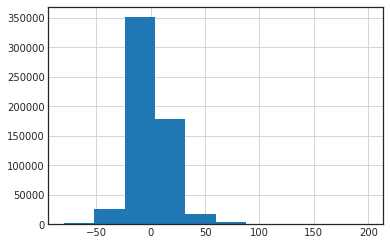

In [104]:
# 2. pEDA #

df.RET.hist()

In [105]:
# explore feature distibution, adjust if seems unreasonable

In [106]:
# add dummies for some missing features

features_miss_dummies = ['amhd', 'BAspr']

for col in features_miss_dummies:
    df[col+'_miss'] = df[col].isnull().astype(int)

df.head()

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
6,10005,381,NaN,-65.203618,1990,-0.57,30.0,0.490174,-0.214332,0.0,-0.230583,-0.610000,-38.367763,NaN,0.765013,0.647098,0.522012,1.4066,0.866870,4.132801,3.099129,NaN,-0.647218,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,21.135115,NaN,-37.167231,0.765013,0.647098,0.710294,4.235715,3.516000,1,1
7,10005,382,NaN,-65.224843,1990,-25.57,30.0,0.490174,-0.214332,0.0,-0.230583,-0.570000,-38.404947,NaN,0.765013,0.647098,0.499827,1.4066,0.866870,4.132835,3.099130,NaN,-0.647218,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.659716,0.765013,0.647098,0.735236,3.367831,3.336151,1,1
8,10005,383,NaN,-72.706514,1990,-0.64,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.380158,NaN,5.732938,5.391287,0.492262,1.4066,5.455535,4.690786,3.473044,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.710657,0.765013,0.647098,0.741531,3.367760,3.336121,1,1
9,10005,384,NaN,-67.514581,1990,-0.69,30.0,0.490174,-0.214332,0.0,-0.230583,-0.640000,-53.826992,NaN,0.765013,0.647098,0.493277,1.4066,0.866870,3.725968,3.473051,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.806772,0.765013,0.647098,0.750895,2.328417,3.336079,1,1
10,10005,385,NaN,-62.951924,1990,-0.68,30.0,0.490174,-0.214332,0.0,-0.230583,-0.690000,-44.500763,NaN,0.765013,0.647098,0.538328,1.4066,0.866870,3.725977,3.313428,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.424011,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-29.825580,3.624354,3.579437,0.776122,1.485171,3.263052,1,1


In [108]:
# 3. Train-test split #

temp_cols = ['PERMNO', 'prd', 'year']

train = df[df.prd<(min_prd+60)]
test = df[df.prd==(min_prd+60)]
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

(151842, 45)

(2544, 45)

,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
6,NaN,-65.203618,-0.57,30.0,0.490174,-0.214332,0.0,-0.230583,-0.610000,-38.367763,NaN,0.765013,0.647098,0.522012,1.4066,0.866870,4.132801,3.099129,NaN,-0.647218,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,21.135115,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,21.135115,NaN,-37.167231,0.765013,0.647098,0.710294,4.235715,3.516000,1,1
7,NaN,-65.224843,-25.57,30.0,0.490174,-0.214332,0.0,-0.230583,-0.570000,-38.404947,NaN,0.765013,0.647098,0.499827,1.4066,0.866870,4.132835,3.099130,NaN,-0.647218,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,1.406600,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.659716,0.765013,0.647098,0.735236,3.367831,3.336151,1,1
8,NaN,-72.706514,-0.64,30.0,0.490174,-0.214332,0.0,-0.230583,-22.380465,-38.380158,NaN,5.732938,5.391287,0.492262,1.4066,5.455535,4.690786,3.473044,NaN,-0.934794,0.75014,-0.084639,0.015282,0.306039,-0.241753,NaN,1.406600,NaN,NaN,21.135115,NaN,NaN,1.4066,NaN,NaN,1.406600,NaN,-43.710657,0.765013,0.647098,0.741531,3.367760,3.336121,1,1


,mom482,mom242,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
305,-52.312316,-46.967739,4.5800,12.0,-1.896125,0.081622,0.510535,-0.101827,-11.5511,6.309380,2.778245,3.727031,3.549946,1.096501,7.4790,3.931532,2.979029,3.420743,4.651163,3.930452,-1.623669,0.013844,0.291257,0.800300,3.961848,2.727015,7.1249,4.651163,2.800786,6.6497,2.040816,2.701712,3.2647,4.545455,2.614138,7.1249,2.272727,-52.929807,3.158877,2.559848,0.934201,3.785383,3.654135,0,0
342,190.634307,170.270066,-10.8046,49.0,-1.862198,0.132619,0.757579,0.335288,-6.2371,105.899232,3.248493,2.666218,2.284620,0.693450,7.5420,2.762798,2.876936,3.023678,1.538462,4.532237,-1.567054,0.019597,0.839508,-0.112930,3.631882,3.821606,18.3306,2.112676,3.981594,5.2462,2.380952,4.302508,3.6897,1.149425,4.874860,18.3306,3.571429,60.701689,2.527816,2.276596,0.329704,3.260048,3.923731,0,0
574,-53.013446,-66.328875,11.8249,21.0,0.177905,-0.082748,0.119668,-0.103007,-11.3491,-51.336416,2.239765,5.899688,5.075038,0.916279,10.7633,6.349370,3.500791,4.053772,5.769231,4.429410,0.670110,0.063815,0.291788,0.003223,5.233018,2.144554,7.3894,1.960784,1.872630,2.7999,2.816901,1.950575,1.7101,2.500000,2.459010,7.3894,3.508772,-22.503955,3.237493,3.095980,0.226650,2.600822,2.612941,0,0


In [109]:
# 4. Missing values #

col_ignore = ['RET']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]

for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
    
display(train.count())

mom482          151842
mom242          151842
RET             151842
ind             151842
bm              151842
op              151842
gp              151842
inv             151842
mom11           151842
mom122          151842
amhd            151842
ivol_capm       151842
ivol_ff5        151842
beta_bw         151842
MAX             151842
vol1m           151842
vol6m           151842
vol12m          151842
BAspr           151842
size            151842
lbm             151842
lop             151842
lgp             151842
linv            151842
llme            151842
l1amhd          151842
l1MAX           151842
l1BAspr         151842
l3amhd          151842
l3MAX           151842
l3BAspr         151842
l6amhd          151842
l6MAX           151842
l6BAspr         151842
l12amhd         151842
l12MAX          151842
l12BAspr        151842
l12mom122       151842
l12ivol_capm    151842
l12ivol_ff5     151842
l12beta_bw      151842
l12vol6m        151842
l12vol12m       151842
amhd_miss  

In [91]:
# [optional] Target Encoding


In [111]:
X_train = train.copy()
y_train = X_train.pop('RET')

X_test = test.copy()
y_test = X_test.pop('RET')

In [112]:
# 5. Feature engineering #

time1 = time.time()

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat),
    ('num', StandardScaler(), col_num)])

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transformation: ', X_train.shape)



Number of features before transformation:  (151842, 44)
time to do feature proprocessing:  0.33363819122314453
Number of features after transformation:  (151842, 92)


In [113]:
# 6. Model fitting #

# first, some trivial baselines:
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

time1 = time.time()
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=6, eta=0.05, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)), time.time()-time1)

mae of a constant model 11.620785167397445
R2 of a constant model 0.0
XGB train: 10.430981677326693 0.1570521115946395 4.102670669555664


In [114]:
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[300, 500], 'max_depth':[2,3,4], 'eta':[0.015, 0.3, 0.05],
             'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='neg_mean_absolute_error')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
# this runs for 40 min and finds 
# 'eta': 0.02, 'max_depth': 6, 'n_estimators': 500, 0.01095415380877135
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=300, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=2, n_estimators=500, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=300, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=4, n_estimators=500, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, eta=0.02, max_depth=6, n_estimators=300, subsample=0.6; tota

In [115]:
# time1 = time.time()

# def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

#     cv_regularizer=0.01
#     # Usually values between 0.1 and 0.2 work fine.

#     params = {
#         "tree_method": 'gpu_hist',
#         "verbosity": 0,  # 0 (silent) - 3 (debug)
#         "n_estimators": trial.suggest_int("n_estimators", 100, 500),
#         "max_depth": trial.suggest_int("max_depth", 2, 10),
#         "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.2),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
#         "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
#         "alpha": trial.suggest_loguniform("alpha", 0.1, 20.0),
#         "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
#         "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
#         "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10)    }
#     # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
#     # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
#     # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

#     temp_out = []

#     for i in range(cv_runs):

#         X = X_train
#         y = y_train

#         model = XGBRegressor(**params, njobs=-1)
#         rkf = KFold(n_splits=n_splits, shuffle=True)
#         X_values = X.values
#         y_values = y.values
#         y_pred = np.zeros_like(y_values)
#         y_pred_train = np.zeros_like(y_values)
#         for train_index, test_index in rkf.split(X_values):
#             X_A, X_B = X_values[train_index, :], X_values[test_index, :]
#             y_A, y_B = y_values[train_index], y_values[test_index]
#             model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
#             y_pred[test_index] += model.predict(X_B)
                      
            
#         #score_train = roc_auc_score(y_train, y_pred_train)
#         score_test = mean_absolute_error(y_train, y_pred) 
#         #overfit = score_train-score_test
#         #temp_out.append(score_test-cv_regularizer*overfit)
#         temp_out.append(score_test)

#     return (np.mean(temp_out))

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=30)

# print('Total time for hypermarameter optimization ', time.time()-time1)
# hp = study.best_params
# for key, value in hp.items():
#     print(f"{key:>20s} : {value}")
# print(f"{'best objective value':>20s} : {study.best_value}")

# optuna_hyperpars = study.best_params
# optuna_hyperpars['tree_method']='gpu_hist'

# optuna_xgb = XGBRegressor(**optuna_hyperpars)
# optuna_xgb.fit(X_train, y_train)
# print('Optuna XGB train:', 
#       mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

[I 2022-08-24 23:46:06,496] A new study created in memory with name: no-name-5899c2a6-1e9c-45f0-867f-b5c8d04531b5
[I 2022-08-24 23:46:08,843] Trial 0 finished with value: 11.062386406243789 and parameters: {'n_estimators': 183, 'max_depth': 4, 'learning_rate': 0.14951239119858067, 'colsample_bytree': 0.3227666017236151, 'subsample': 0.6634755481305934, 'alpha': 2.6683951715182603, 'lambda': 0.7944142581307534, 'gamma': 5.693282603641172, 'min_child_weight': 0.29973231223569663}. Best is trial 0 with value: 11.062386406243789.
[I 2022-08-24 23:46:15,413] Trial 1 finished with value: 11.44074121643136 and parameters: {'n_estimators': 393, 'max_depth': 6, 'learning_rate': 0.19797663812669192, 'colsample_bytree': 0.11882552449869285, 'subsample': 0.8119682019775221, 'alpha': 5.244752216912319, 'lambda': 2.1648838126231453, 'gamma': 9.477597245019747e-05, 'min_child_weight': 3.7260130033624184}. Best is trial 0 with value: 11.062386406243789.
[I 2022-08-24 23:46:24,501] Trial 2 finished wit

Total time for hypermarameter optimization  405.7701807022095
        n_estimators : 251
           max_depth : 9
       learning_rate : 0.00552085361772124
    colsample_bytree : 0.5277864219584348
           subsample : 0.606405534975936
               alpha : 7.793587721599955
              lambda : 97.86225592919749
               gamma : 3.4178310856885307e-07
    min_child_weight : 0.6847952631196979
best objective value : 10.925263094849582
Optuna XGB train: 10.781206984149076 0.04133710910132482 418.38148379325867


In [116]:
# Evaluate performance of XGB models:

print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_score(y_test, xgbm.predict(X_test)))
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

XGB test: 10.233213915191632 -0.003467503699573271
XGB GS test: 10.163871457977189 0.027802299459069535
Optuna XGB test: 10.207752342040264 0.006956006121909386


In [ ]:
# test_size = 0.1
# df.reset_index(inplace=True, drop=True)
# #random.seed(2)
# test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
# train = df.iloc[list(set(df.index)-set(test_index))]
# test = df.iloc[test_index]
# train.reset_index(drop=True, inplace=True)
# test.reset_index(drop=True, inplace=True)
# display(train.shape, test.shape, train.head(3), test.head(3))